In [29]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from scipy.special import softmax
from abc import ABC, abstractmethod
from copy import deepcopy
import multiprocessing as mp
from tqdm.notebook import tqdm


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("../JC.mplstyle")


In [30]:
class Strategy(ABC):
    def __init__(self, k_arm):
        self.k_arm = k_arm

    @abstractmethod
    def choose_action(self):
        pass

    @abstractmethod
    def update_q_est(self, action, reward, average_reward):
        pass

    def initialize(self):
        self.q_est = np.zeros(self.k_arm)
        self.action_count = np.zeros(self.k_arm)


In [31]:
class EpsilonGreedy(Strategy):
    def __init__(self, k_arm, alpha, epsilon):
        super().__init__(k_arm)
        self.alpha = alpha
        self.epsilon = epsilon

    def choose_action(self):
        if np.random.random() < self.epsilon:
            action = np.random.randint(low=0, high=self.k_arm)
        else:
            action = np.random.choice(np.flatnonzero(self.q_est == self.q_est.max()))

        self.action_count[action] += 1
        return action

    def update_q_est(self, action, reward, average_reward):
        if self.alpha is None:
            self.q_est[action] += (reward - self.q_est[action]) / self.action_count[action]
        else:
            self.q_est[action] += (reward - self.q_est[action]) * self.alpha



In [32]:
class OptimisticStrategy(EpsilonGreedy):
    def __init__(self, k_arm, alpha, epsilon, initial_value):
        super().__init__(k_arm, alpha, epsilon)
        self.initial_value = initial_value

    def initialize(self):
        self.q_est = np.ones(self.k_arm)*self.initial_value
        self.action_count = np.zeros(self.k_arm)



In [33]:
class GradientBanditStrategy(Strategy):
    def __init__(self, k_arm, alpha, baseline=True):
        super().__init__(k_arm)
        self.alpha = alpha
        self.baseline = baseline

    def choose_action(self):
        p_action = softmax(self.q_est)
        action = np.random.choice(np.arange(self.k_arm), p=p_action)
        self.action_count[action] += 1
        return action

    def update_q_est(self, action, reward, average_reward):
        temp = np.zeros(self.k_arm)
        temp[action] = 1
        p_action = softmax(self.q_est)
        if self.baseline is True:
            self.q_est += (reward - average_reward) * self.alpha * (temp - p_action)
        else:
            self.q_est += reward * self.alpha * (temp - p_action)


In [34]:
class Bandit:
    def __init__(self, k_arm, time_steps, set_size, strategy):
        self.k_arm = k_arm
        self.time_steps = time_steps
        self.set_size = set_size
        self.average_reward = None
        self.optimal_action = None
        self.strategy = strategy

    def simulate_one_set(self,strategy):
        q = np.random.standard_normal(size=self.k_arm)
        reward_list = []
        optimal_list = []
        average_reward = 0
        strategy.initialize()

        for i_step in range(self.time_steps):
            q = self.update_true_values(q)
            optimal_action = np.argmax(q)

            action = strategy.choose_action()
            optimal_list.append(action == optimal_action)
            reward = np.random.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            average_reward += (reward - average_reward)/(i_step+1)
            strategy.update_q_est(action, reward, average_reward)
        return reward_list, optimal_list
    
    def simulate(self):
        total_reward = []
        total_optimal = []

        for i_set in tqdm(range(self.set_size)):
            reward_list, optimal_list = self.simulate_one_set(deepcopy(self.strategy))
            total_reward.append(reward_list)
            total_optimal.append(optimal_list)

        self.average_reward = np.array(total_reward).mean(axis=0)
        self.optimal_action = np.array(total_optimal).mean(axis=0)

    def update_true_values(self, q):
        return q
        
    def plot_strategy(self, ax):
        ax[0].plot(np.arange(self.time_steps), self.average_reward, linewidth=1)
        ax[0].set_ylabel('Average Reward')
        ax[0].set_xlabel("Steps")
        ax[1].plot(np.arange(self.time_steps), self.optimal_action, linewidth=1)
        ax[1].set_ylabel("Optimal Action (%)")
        ax[1].set_ylim([0, 1])
        ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax[1].set_xlabel("Steps")

In [ ]:
class NonStationaryBandit(Bandit):
    def __init__(self, k_arm, time_steps, set_size, random_walk_scale, strategy):
        super().__init__(k_arm, time_steps, set_size, strategy)
        self.random_walk_scale=random_walk_scale
    
    def update_true_values(self, q):
        return q + np.random.normal(loc=0, scale=self.random_walk_scale, size=self.k_arm)

class SpecialBandit(Bandit):
    def simulate_one_set(self, strategy):
        q = np.random.normal(loc=4, scale=1, size=self.k_arm)
        reward_list = []
        optimal_list = []
        average_reward = 0
        strategy.initialize()

        for i_step in range(self.time_steps):
            q = self.update_true_values(q)
            optimal_action = np.argmax(q)

            action = strategy.choose_action()
            optimal_list.append(action == optimal_action)
            reward = np.random.normal(loc=q[action], scale=1)
            reward_list.append(reward)
            average_reward += (reward - average_reward)/(i_step+1)
            strategy.update_q_est(action, reward, average_reward)
        return reward_list, optimal_list


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

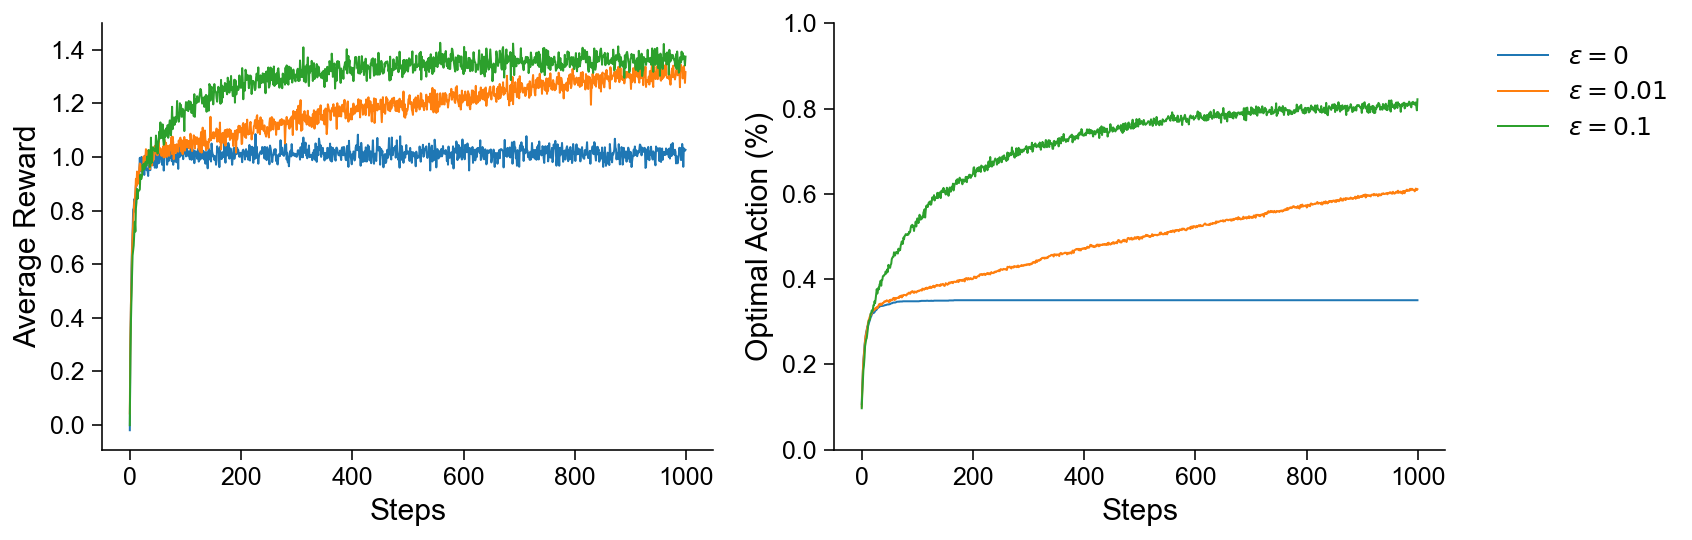

In [9]:
epsilon_list = [0, 0.01, 0.1]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for epsilon in epsilon_list:
    strategy = EpsilonGreedy(k_arm=10, epsilon=epsilon, alpha=None)
    bandit = Bandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy)
    bandit.simulate()
    bandit.plot_strategy(ax)
plt.legend([r'$\epsilon=0$', r'$\epsilon=0.01$', r'$\epsilon=0.1$'], bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

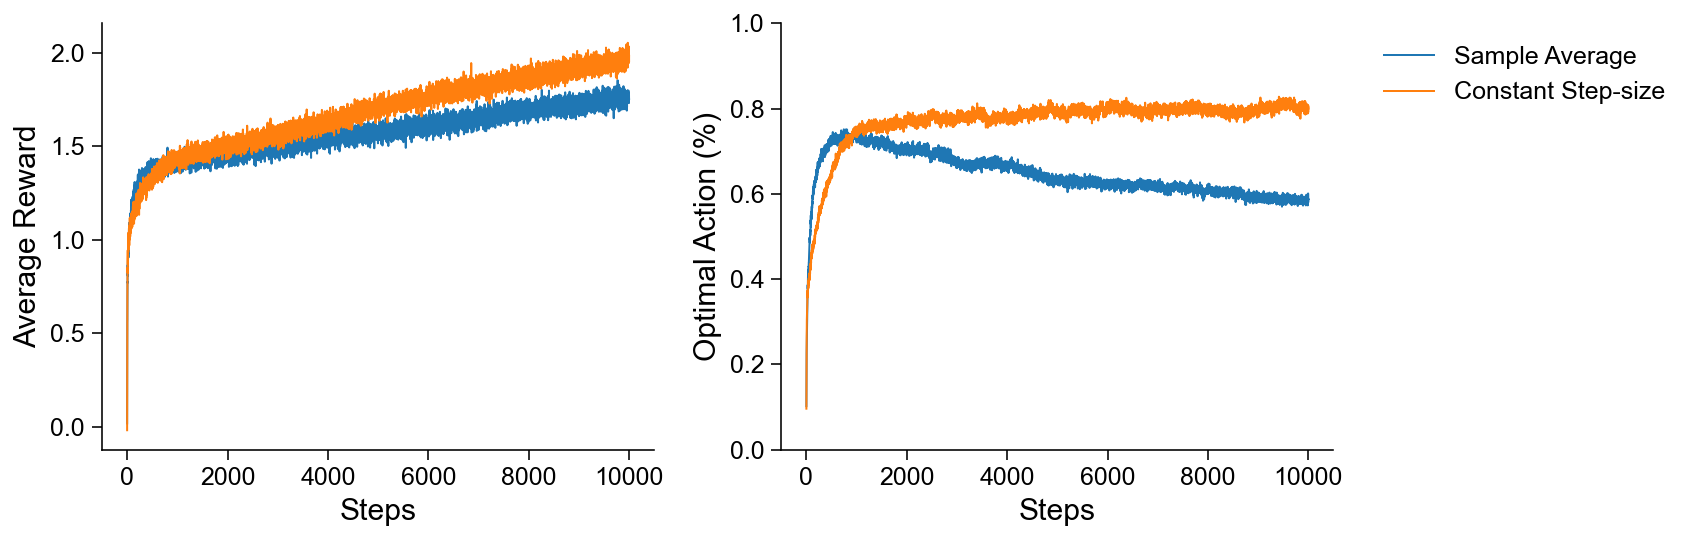

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
alpha_list = [None, 0.1]
for alpha in alpha_list:
    strategy = EpsilonGreedy(k_arm=10, epsilon=0.1, alpha=alpha)
    bandit = NonStationaryBandit(k_arm=10, time_steps=10000, set_size=2000, random_walk_scale=0.01, strategy=strategy)
    bandit.simulate()
    bandit.plot_strategy(ax)

plt.legend(["Sample Average", 'Constant Step-size'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

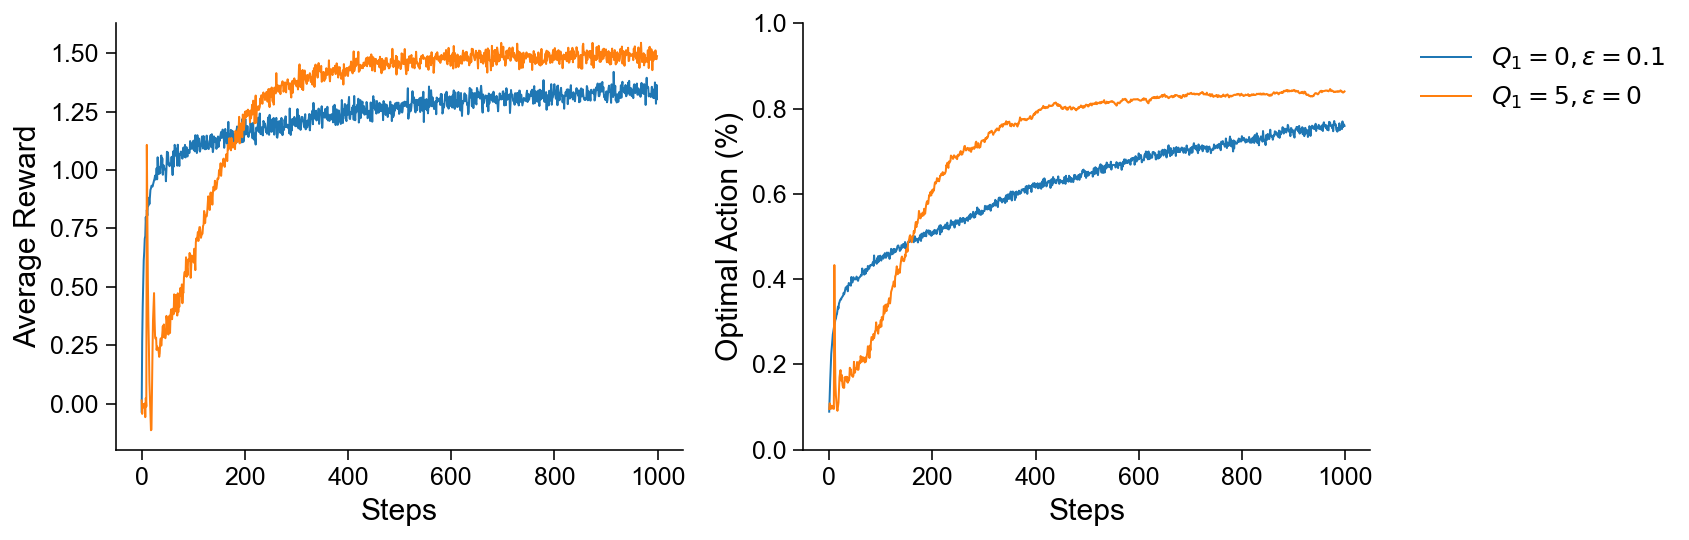

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
strategy1 = OptimisticStrategy(k_arm=10, epsilon=0.1, alpha=0.1, initial_value=0)
bandit1 = Bandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy1)
bandit1.simulate()
bandit1.plot_strategy(ax)
strategy2 = OptimisticStrategy(k_arm=10, epsilon=0, alpha=0.1, initial_value=5)
bandit2 = Bandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy2)
bandit2.simulate()
bandit2.plot_strategy(ax)
plt.legend([r'$Q_{1}=0,\epsilon=0.1$', r'$Q_{1}=5,\epsilon=0$'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

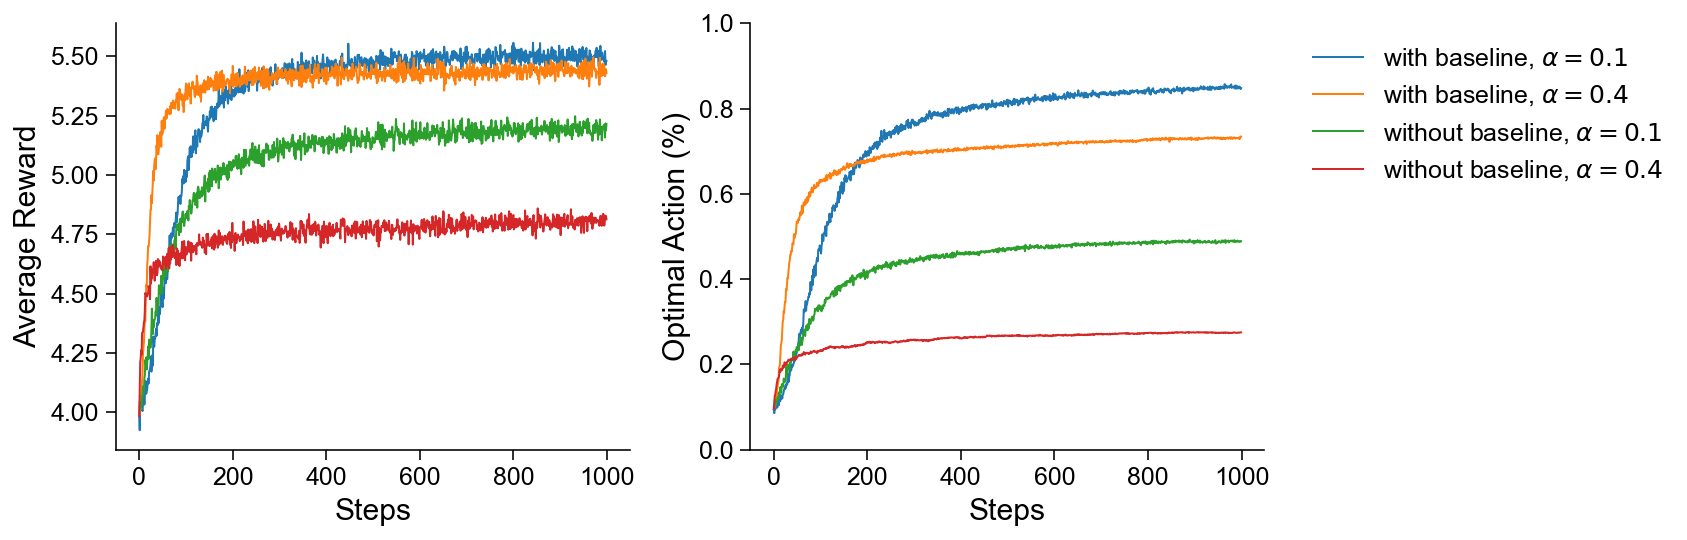

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
strategy1 = GradientBanditStrategy(k_arm=10, alpha=0.1, baseline=True)
bandit = SpecialBandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy1)
bandit.simulate()
bandit.plot_strategy(ax)
strategy2 = GradientBanditStrategy(k_arm=10, alpha=0.4, baseline=True)
bandit = SpecialBandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy2)
bandit.simulate()
bandit.plot_strategy(ax)
strategy3 = GradientBanditStrategy(k_arm=10, alpha=0.1, baseline=False)
bandit = SpecialBandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy3)
bandit.simulate()
bandit.plot_strategy(ax)
strategy4 = GradientBanditStrategy(k_arm=10, alpha=0.4, baseline=False)
bandit = SpecialBandit(k_arm=10, time_steps=1000, set_size=2000, strategy=strategy4)
bandit.simulate()
bandit.plot_strategy(ax)
plt.legend([r'with baseline, $\alpha=0.1$', r'with baseline, $\alpha=0.4$', r'without baseline, $\alpha=0.1$', r'without baseline, $\alpha=0.4$'], bbox_to_anchor = (1.05, 1.0), loc="upper left")
plt.show()